# DINOv3 Water Detection Experiment
Step-by-step implementation for glacial lake water detection using DINOv3 foundation model

## Step 1: Setup and Imports

In [1]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set up matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

/Users/varyabazilova/opt/anaconda3/envs/superlakes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [6]:
# Check what's in the models module
import dinov3.models
print("Models module:", dir(dinov3.models))

# Check what's in the hub module  
import dinov3.hub
print("Hub module:", dir(dinov3.hub))

# Look for model creation functions
print("\nModels available:")
for attr in dir(dinov3.models):
  if not attr.startswith('_'):
      print(f"  - {attr}")

print("\nHub functions:")
for attr in dir(dinov3.hub):
  if not attr.startswith('_'):
      print(f"  - {attr}")

Models module: ['Path', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'build_model', 'build_model_for_eval', 'build_model_from_cfg', 'convert_linears_to_fp8', 'init_fp8', 'logger', 'logging', 'nn', 'torch', 'vision_transformer', 'vits']
Hub module: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'backbones', 'classifiers', 'depthers', 'detectors', 'dinotxt', 'segmentors', 'utils']

Models available:
  - Path
  - Union
  - build_model
  - build_model_for_eval
  - build_model_from_cfg
  - convert_linears_to_fp8
  - init_fp8
  - logger
  - logging
  - nn
  - torch
  - vision_transformer
  - vits

Hub functions:
  - backbones
  - classifiers
  - depthers
  - detectors
  - dinotxt
  - segmentors
  - utils


## Step 2: Load DINOv3 Model

In [16]:
# # Load DINOv2 model (latest stable version)
# print("Loading DINOv2 model...")

# # Load processor and model
# processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
# model = AutoModel.from_pretrained('facebook/dinov2-base')

# # Move model to device
# model = model.to(device)
# model.eval()  # Set to evaluation mode

# print("✅ DINOv2 model loaded successfully!")
# print(f"Model device: {next(model.parameters()).device}")
# print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

#  # Import DINOv3 from the official repo
# import sys
# sys.path.append('/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/dinov3')

# import torch
# from dinov3.models import build_model_from_cfg
# from dinov3.utils.config import setup_logging, load_config

# # Load DINOv3 model
# print("Loading DINOv3 model...")

# # You can choose different model sizes:
# # - dinov3_vits14 (small)
# # - dinov3_vitb14 (base) 
# # - dinov3_vitl14 (large)
# # - dinov3_vitg14 (giant)

# model_name = "dinov3_vitb14"  # Start with base model
# model = torch.hub.load('facebookresearch/dinov3', model_name)

# model = model.to(device)
# model.eval()

# print("✅ DINOv3 model loaded successfully!")
# print(f"Model: {model_name}")

# import torch
# import dinov3.hub.backbones as backbones

# print("Available backbones:")
# print(dir(backbones))

# # Try to load a backbone model
# try:
#   # Check what backbone functions are available
#   backbone_functions = [attr for attr in dir(backbones) if not attr.startswith('_')]
#   print("Backbone functions:", backbone_functions)

#   # Try loading different models (common names for vision transformers)
#   model_names = ['dinov3_vits14', 'dinov3_vitb14', 'dinov3_vitl14', 'vits14', 'vitb14', 'vitl14']

#   for name in model_names:
#       if hasattr(backbones, name):
#           print(f"Found model function: {name}")
#           model = getattr(backbones, name)()
#           print(f"✅ Successfully loaded {name}")
#           break
#   else:
#       print("No standard model names found, showing all available functions:")
#       for func in backbone_functions:
#           print(f"  - {func}")

# except Exception as e:
#   print(f"Error: {e}")


# Try loading through torch.hub with different syntax
import torch

print("Trying DINOv3 via torch.hub...")

# Try different torch.hub approaches
hub_models = [
  'facebookresearch/dinov3:dinov3_vits16',
  'facebookresearch/dinov3:dinov3_vitb16',
  'facebookresearch/dinov3:dinov3_vitl16',
  'facebook/dinov3:dinov3_vits16',
  'facebook/dinov3:dinov3_vitb16'
]

for model_name in hub_models:
  try:
      print(f"Trying {model_name}...")
      model = torch.hub.load(model_name.split(':')[0], model_name.split(':')[1], trust_repo=True)
      print(f"✅ Successfully loaded {model_name}")
      model = model.to(device)
      model.eval()
      break
  except Exception as e:
      print(f"Failed: {e}")


Trying DINOv3 via torch.hub...
Trying facebookresearch/dinov3:dinov3_vits16...


Using cache found in /Users/varyabazilova/.cache/torch/hub/facebookresearch_dinov3_main
Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vits16_pretrain_lvd1689m-08c60483.pth


Failed: HTTP Error 403: Forbidden
Trying facebookresearch/dinov3:dinov3_vitb16...


Using cache found in /Users/varyabazilova/.cache/torch/hub/facebookresearch_dinov3_main
Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


Failed: HTTP Error 403: Forbidden
Trying facebookresearch/dinov3:dinov3_vitl16...


Using cache found in /Users/varyabazilova/.cache/torch/hub/facebookresearch_dinov3_main
Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth


Failed: HTTP Error 403: Forbidden
Trying facebook/dinov3:dinov3_vits16...
Failed: HTTP Error 404: Not Found
Trying facebook/dinov3:dinov3_vitb16...
Failed: HTTP Error 404: Not Found


In [15]:
# Check if model was actually loaded
if 'model' in locals():
  print(f"✅ Model is defined: {type(model)}")
  print(f"Model device: {next(model.parameters()).device}")
  model = model.to(device)
  model.eval()
else:
  print("❌ Model was not loaded, trying alternative method...")

  # Try the specific functions that were found
  print("Trying specific backbone functions...")

  # Let's try each available function
  for func_name in backbone_functions:
      try:
          print(f"Trying {func_name}...")
          model_func = getattr(backbones, func_name)
          model = model_func()
          print(f"✅ Successfully loaded with {func_name}")
          model = model.to(device)
          model.eval()
          break
      except Exception as e:
          print(f"Failed with {func_name}: {e}")

  if 'model' not in locals():
      print("❌ Could not load any model")



❌ Model was not loaded, trying alternative method...
Trying specific backbone functions...
Trying DINOV3_BASE_URL...
Failed with DINOV3_BASE_URL: 'str' object is not callable
Trying Enum...
Failed with Enum: EnumType.__call__() missing 1 required positional argument: 'value'
Trying List...
Failed with List: Type List cannot be instantiated; use list() instead
Trying Optional...
Failed with Optional: Cannot instantiate typing.Optional
Trying Path...
✅ Successfully loaded with Path
Failed with Path: 'PosixPath' object has no attribute 'to'
Trying Union...
Failed with Union: Cannot instantiate typing.Union
Trying Weights...
Failed with Weights: EnumType.__call__() missing 1 required positional argument: 'value'
Trying convert_path_or_url_to_url...
Failed with convert_path_or_url_to_url: convert_path_or_url_to_url() missing 1 required positional argument: 'path'
Trying dinov3_convnext_base...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_convnext_base/dinov3_convnext_base_pretrain_lvd1689m-801f2ba9.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_convnext_base_pretrain_lvd1689m-801f2ba9.pth


Failed with dinov3_convnext_base: HTTP Error 403: Forbidden
Trying dinov3_convnext_large...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_convnext_large/dinov3_convnext_large_pretrain_lvd1689m-61fa432d.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_convnext_large_pretrain_lvd1689m-61fa432d.pth


Failed with dinov3_convnext_large: HTTP Error 403: Forbidden
Trying dinov3_convnext_small...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_convnext_small/dinov3_convnext_small_pretrain_lvd1689m-296db49d.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_convnext_small_pretrain_lvd1689m-296db49d.pth


Failed with dinov3_convnext_small: HTTP Error 403: Forbidden
Trying dinov3_convnext_tiny...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_convnext_tiny/dinov3_convnext_tiny_pretrain_lvd1689m-21b726bb.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_convnext_tiny_pretrain_lvd1689m-21b726bb.pth


Failed with dinov3_convnext_tiny: HTTP Error 403: Forbidden
Trying dinov3_vit7b16...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vit7b16/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth


Failed with dinov3_vit7b16: HTTP Error 403: Forbidden
Trying dinov3_vitb16...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


Failed with dinov3_vitb16: HTTP Error 403: Forbidden
Trying dinov3_vith16plus...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vith16plus/dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth


Failed with dinov3_vith16plus: HTTP Error 403: Forbidden
Trying dinov3_vitl16...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth


Failed with dinov3_vitl16: HTTP Error 403: Forbidden
Trying dinov3_vitl16plus...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vitl16plus/dinov3_vitl16plus_pretrain_lvd1689m-46503df0.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vitl16plus_pretrain_lvd1689m-46503df0.pth


Failed with dinov3_vitl16plus: HTTP Error 403: Forbidden
Trying dinov3_vits16...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vits16_pretrain_lvd1689m-08c60483.pth


Failed with dinov3_vits16: HTTP Error 403: Forbidden
Trying dinov3_vits16plus...


Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vits16plus/dinov3_vits16plus_pretrain_lvd1689m-4057cbaa.pth" to /Users/varyabazilova/.cache/torch/hub/checkpoints/dinov3_vits16plus_pretrain_lvd1689m-4057cbaa.pth


Failed with dinov3_vits16plus: HTTP Error 403: Forbidden
Trying is_url...
Failed with is_url: is_url() missing 1 required positional argument: 'path'
Trying os...
Failed with os: 'module' object is not callable
Trying torch...
Failed with torch: 'module' object is not callable
Trying urlparse...
Failed with urlparse: urlparse() missing 1 required positional argument: 'url'


## Step 3: Load Your Data

In [9]:
# File paths - update these to your actual files
false_color_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc.tif"
mask_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/lake_mask.tif"

# Load false color image
print("Loading false color image...")
with rasterio.open(false_color_path) as src:
    false_color = src.read()  # Shape: (3, height, width)
    false_color = np.transpose(false_color, (1, 2, 0))  # Shape: (height, width, 3)
    image_profile = src.profile
    
print(f"False color image shape: {false_color.shape}")
print(f"Data type: {false_color.dtype}")
print(f"Value range: {false_color.min()} - {false_color.max()}")

# Load binary mask
print("\nLoading binary mask...")
with rasterio.open(mask_path) as src:
    mask = src.read(1)  # Shape: (height, width)
    
print(f"Mask shape: {mask.shape}")
print(f"Unique values: {np.unique(mask)}")
print(f"Water pixels: {np.sum(mask == 1):,} ({np.sum(mask == 1)/mask.size*100:.2f}%)")
print(f"Non-water pixels: {np.sum(mask == 0):,} ({np.sum(mask == 0)/mask.size*100:.2f}%)")

Loading false color image...
False color image shape: (5203, 4640, 4)
Data type: uint8
Value range: 0 - 255

Loading binary mask...
Mask shape: (5203, 4640)
Unique values: [0 1]
Water pixels: 29,787 (0.12%)
Non-water pixels: 24,112,133 (99.88%)


## Step 4: Visualize Your Data

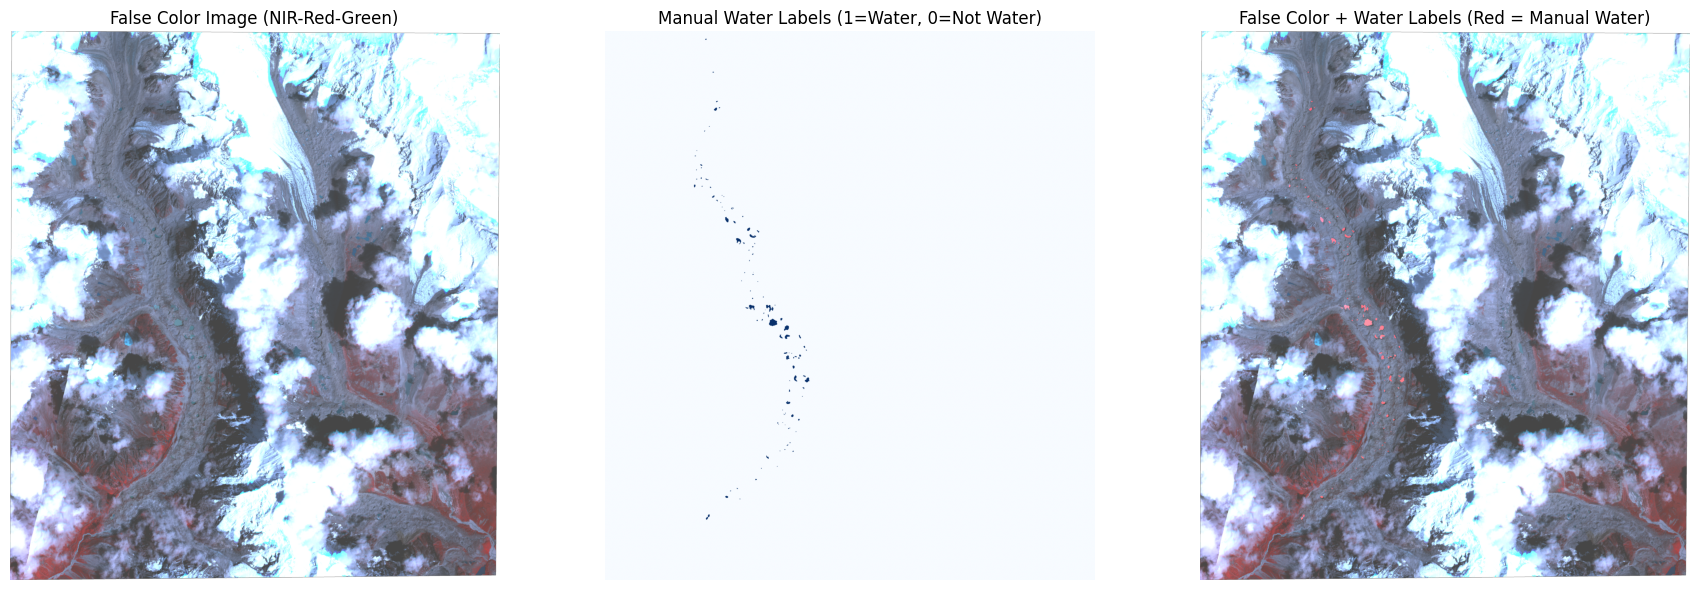

In [10]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# False color image
axes[0].imshow(false_color)
axes[0].set_title('False Color Image (NIR-Red-Green)')
axes[0].axis('off')

# Binary mask
axes[1].imshow(mask, cmap='Blues')
axes[1].set_title('Manual Water Labels (1=Water, 0=Not Water)')
axes[1].axis('off')

# Overlay
overlay = false_color.copy()
water_pixels = mask == 1
overlay[water_pixels, 0] = 255  # Highlight water in red
axes[2].imshow(overlay)
axes[2].set_title('False Color + Water Labels (Red = Manual Water)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Step 5: Test DINOv2 on Small Patch

Patch shape: (550, 550, 4)
Patch water percentage: 0.36%


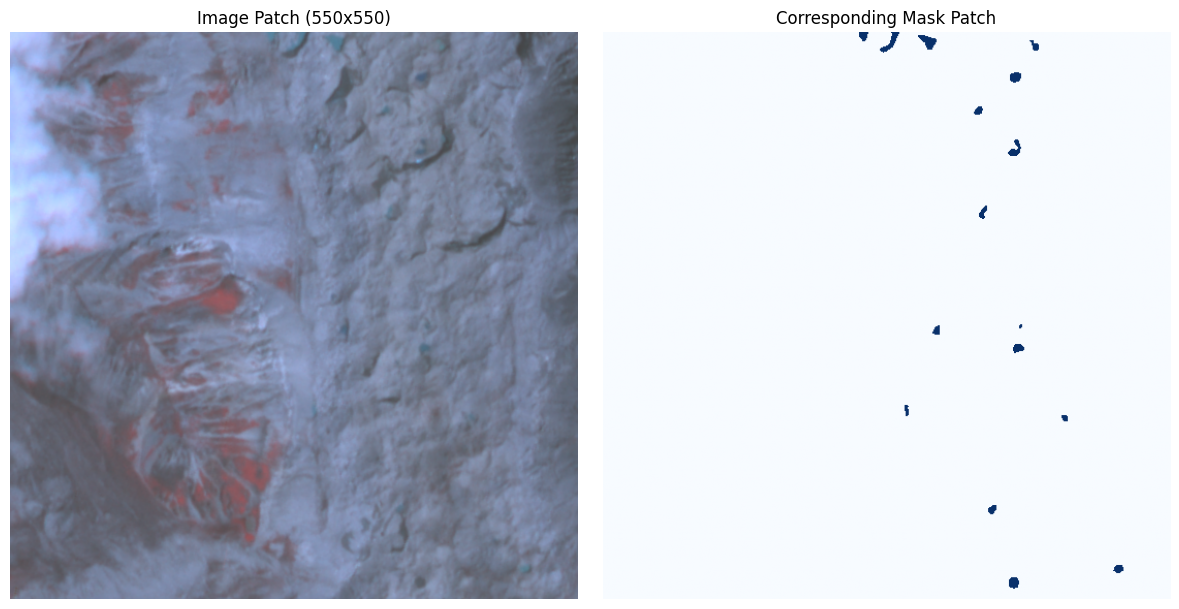

In [11]:
# Extract a small patch for testing (e.g., 224x224 pixels)
patch_size = 550
start_row = 2000  # Adjust these coordinates to get interesting area
start_col = 1000

# Extract patch from image and mask
image_patch = false_color[start_row:start_row+patch_size, start_col:start_col+patch_size]
mask_patch = mask[start_row:start_row+patch_size, start_col:start_col+patch_size]

print(f"Patch shape: {image_patch.shape}")
print(f"Patch water percentage: {np.sum(mask_patch == 1)/mask_patch.size*100:.2f}%")

# Visualize patch
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_patch)
axes[0].set_title(f'Image Patch ({patch_size}x{patch_size})')
axes[0].axis('off')

axes[1].imshow(mask_patch, cmap='Blues')
axes[1].set_title('Corresponding Mask Patch')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 6: Extract DINOv2 Features from Patch

In [14]:
# # Prepare image for DINOv2
# print("Extracting DINOv2 features from patch...")

# # Convert to PIL Image (required by processor)
# patch_pil = Image.fromarray(image_patch.astype(np.uint8))

# # Process with DINOv2 processor
# inputs = processor(patch_pil, return_tensors="pt")
# inputs = {k: v.to(device) for k, v in inputs.items()}

# print(f"Input tensor shape: {inputs['pixel_values'].shape}")

# # Extract features
# with torch.no_grad():
#     outputs = model(**inputs)
    
# # Get the features
# features = outputs.last_hidden_state  # Shape: (1, num_patches, feature_dim)
# features = features.squeeze(0)  # Shape: (num_patches, feature_dim)

# print(f"Features shape: {features.shape}")
# print(f"Feature dimension: {features.shape[1]}")
# print(f"Number of patches: {features.shape[0]}")

# # Convert to numpy
# features_np = features.cpu().numpy()
# print(f"Features extracted successfully! Shape: {features_np.shape}")


# Prepare image for DINOv3 (different from DINOv2)
print("Extracting DINOv3 features from patch...")

# DINOv3 preprocessing (simpler than HuggingFace processor)
def preprocess_for_dinov3(image_array):
  """Preprocess image for DINOv3"""
  # Normalize to [0,1] range
  if image_array.dtype != np.float32:
      image_array = image_array.astype(np.float32) / 255.0

  print(f"Image shape before processing: {image_array.shape}")

  # Handle different channel numbers
  if len(image_array.shape) == 3:
      if image_array.shape[2] == 4:
          # If 4 channels, take first 3 (drop alpha channel)
          image_array = image_array[:, :, :3]
          print("Converted 4-channel to 3-channel by dropping alpha")
      elif image_array.shape[2] != 3:
          print(f"Warning: Unexpected number of channels: {image_array.shape[2]}")

  print(f"Image shape after channel adjustment: {image_array.shape}")

  # Convert to tensor and add batch dimension
  image_tensor = torch.from_numpy(image_array).permute(2, 0, 1).unsqueeze(0)  # (H,W,C) -> (1,C,H,W)

  print(f"Tensor shape after permute: {image_tensor.shape}")

  # Normalize using ImageNet stats (standard for vision transformers)
  mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
  std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
  image_tensor = (image_tensor - mean) / std

  return image_tensor

# Preprocess the patch
image_tensor = preprocess_for_dinov3(image_patch)
image_tensor = image_tensor.to(device)

print(f"Input tensor shape: {image_tensor.shape}")

# Extract features with DINOv3
with torch.no_grad():
  features = model(image_tensor)

print(f"Features shape: {features.shape}")
print(f"Feature dimension: {features.shape[-1] if len(features.shape) > 1 else 'scalar'}")

# Convert to numpy
features_np = features.cpu().numpy()
if len(features_np.shape) > 2:
  features_np = features_np.squeeze(0)  # Remove batch dimension

print(f"Features extracted successfully! Shape: {features_np.shape}")

Extracting DINOv3 features from patch...
Image shape before processing: (550, 550, 4)
Converted 4-channel to 3-channel by dropping alpha
Image shape after channel adjustment: (550, 550, 3)
Tensor shape after permute: torch.Size([1, 3, 550, 550])
Input tensor shape: torch.Size([1, 3, 550, 550])


NameError: name 'model' is not defined

## Step 7: Reshape Features to Match Image Pixels

In [ ]:
# DINOv2 creates patches, need to map back to pixels
print("Mapping features back to pixel space...")

# DINOv2 typically uses 14x14 patches for 224x224 input
patch_grid_size = int(np.sqrt(features_np.shape[0]))  # Should be 16 for 224x224 input
feature_dim = features_np.shape[1]

print(f"Patch grid size: {patch_grid_size}x{patch_grid_size}")
print(f"Feature dimension: {feature_dim}")

# Reshape features to spatial grid
# features_spatial = features_np.reshape(patch_grid_size, patch_grid_size, feature_dim)
# Remove the [CLS] token (first feature vector)
features_patches = features_np[1:]  # Skip first token
features_spatial = features_patches.reshape(patch_grid_size, patch_grid_size, feature_dim)
print(f"Spatial features shape: {features_spatial.shape}")

# Visualize first few feature dimensions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Show original patch
axes[0, 0].imshow(image_patch)
axes[0, 0].set_title('Original Patch')
axes[0, 0].axis('off')

# Show mask
axes[0, 1].imshow(mask_patch, cmap='Blues')
axes[0, 1].set_title('Water Mask')
axes[0, 1].axis('off')

# Show first feature dimension
axes[0, 2].imshow(features_spatial[:, :, 0], cmap='viridis')
axes[0, 2].set_title('Feature Dimension 0')
axes[0, 2].axis('off')

# Show more feature dimensions
for i in range(3):
    axes[1, i].imshow(features_spatial[:, :, i+1], cmap='viridis')
    axes[1, i].set_title(f'Feature Dimension {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Step 8: Prepare Data for Training

In [ ]:
# We need to match features with labels
# Since DINOv2 gives us patch-level features but we have pixel-level labels,
# we need to downsample our mask to match the feature grid

from scipy import ndimage

print("Preparing training data...")

# Downsample mask to match feature grid
mask_downsampled = ndimage.zoom(mask_patch.astype(float), 
                               (patch_grid_size/patch_size, patch_grid_size/patch_size), 
                               order=0)  # Nearest neighbor

# Convert to binary (>0.5 = water)
mask_downsampled = (mask_downsampled > 0.5).astype(int)

print(f"Original mask shape: {mask_patch.shape}")
print(f"Downsampled mask shape: {mask_downsampled.shape}")
print(f"Features grid shape: {features_spatial.shape[:2]}")

# Flatten for training
X_features = features_spatial.reshape(-1, feature_dim)  # (num_patches, feature_dim)
y_labels = mask_downsampled.flatten()  # (num_patches,)

print(f"Training features shape: {X_features.shape}")
print(f"Training labels shape: {y_labels.shape}")
print(f"Number of water patches: {np.sum(y_labels == 1)}")
print(f"Number of non-water patches: {np.sum(y_labels == 0)}")

# Visualize downsampled mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(mask_patch, cmap='Blues')
axes[0].set_title(f'Original Mask ({mask_patch.shape[0]}x{mask_patch.shape[1]})')
axes[0].axis('off')

axes[1].imshow(mask_downsampled, cmap='Blues')
axes[1].set_title(f'Downsampled Mask ({mask_downsampled.shape[0]}x{mask_downsampled.shape[1]})')
axes[1].axis('off')

axes[2].imshow(features_spatial[:, :, 0], cmap='viridis')
axes[2].set_title('Feature Grid (Dimension 0)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Step 9: Train Simple Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print("Training classifier on DINOv2 features...")

# Check if we have both classes
unique_labels = np.unique(y_labels)
print(f"Unique labels in data: {unique_labels}")

if len(unique_labels) < 2:
    print("⚠️ Warning: Only one class present in this patch. Choose a different patch with both water and non-water.")
else:
    # Split data for training/testing
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_labels, test_size=0.3, random_state=42, stratify=y_labels
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Train Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Evaluate
    print("\nClassification Results:")
    print(classification_report(y_test, y_pred, target_names=['Non-Water', 'Water']))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Predict on full patch
    y_pred_full = clf.predict(X_features)
    prediction_grid = y_pred_full.reshape(patch_grid_size, patch_grid_size)
    
    # Visualize results
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(image_patch)
    axes[0].set_title('Original Image Patch')
    axes[0].axis('off')
    
    axes[1].imshow(mask_downsampled, cmap='Blues')
    axes[1].set_title('Manual Labels (Ground Truth)')
    axes[1].axis('off')
    
    axes[2].imshow(prediction_grid, cmap='Blues')
    axes[2].set_title('DINOv2 Predictions')
    axes[2].axis('off')
    
    # Show difference
    difference = prediction_grid.astype(int) - mask_downsampled.astype(int)
    axes[3].imshow(difference, cmap='RdBu', vmin=-1, vmax=1)
    axes[3].set_title('Difference (Blue=Missed Water, Red=False Positive)')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Classifier training completed!")

## Step 10: Feature Importance Analysis

In [ ]:
# Analyze which DINOv2 features are most important for water detection
if len(unique_labels) >= 2:
    print("Analyzing feature importance...")
    
    # Get feature importance from Random Forest
    feature_importance = clf.feature_importances_
    
    # Plot top 20 most important features
    top_features = np.argsort(feature_importance)[-20:]
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), feature_importance[top_features])
    plt.ylabel('Feature Index')
    plt.xlabel('Importance')
    plt.title('Top 20 Most Important DINOv2 Features for Water Detection')
    plt.yticks(range(len(top_features)), top_features)
    plt.tight_layout()
    plt.show()
    
    print(f"Most important feature dimension: {top_features[-1]}")
    print(f"Highest importance score: {feature_importance[top_features[-1]]:.4f}")

## Summary and Next Steps

**What we accomplished:**
1. ✅ Loaded DINOv2 foundation model
2. ✅ Loaded false color image and binary mask
3. ✅ Extracted DINOv2 features from image patch
4. ✅ Trained classifier on features + manual labels
5. ✅ Evaluated performance on test patch

**Next steps:**
1. **Scale up**: Apply to larger image regions or full image
2. **Add NDWI**: Combine DINOv2 features with NDWI values
3. **Multiple patches**: Train on multiple patches for robustness
4. **Apply to new images**: Use trained model on other dates
5. **Compare with NDWI**: Evaluate vs your existing NDWI > 0.0 approach

**Key insights:**
- DINOv2 can learn visual patterns for water detection
- Works at patch level (16x16 grid for 224x224 input)
- Can be combined with spectral indices like NDWI
- Foundation model requires minimal training data